# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History



### Results that did the best from Decision Tree Classifier with player diff + one hot encoded categorial features:


# Summary of Results




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


from datetime import datetime
import pickle
import json
import os
import sys
import re
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
import util.model_util as mu
from util.model_util import RSTATE, N_JOBS, MAX_ITER, LABEL_COL
from sklearn.model_selection import train_test_split


%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "ohe-stats"

# sometimes I run these notebooks via command line. Environment variable is set so we know whether we are in DEBUG mode or not
# if you want to manually run this in DEBUG mode, change default value to True
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

if DEBUG:
    ModelWrapper.REPORT_FILE = '../reports/summary-test.csv'
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
    DESCRIPTION = f"{DESCRIPTION}-test"

else:
    # update this
    FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
features = pd.read_csv(FEATURE_FILE)


In [17]:
labels = features[LABEL_COL]

# Gradient Boosting - Baseline

If I didn't know anything about tennis, I would use seed diff to make my predictions.

From EDA, this should result in about 65% accuracy

In [15]:
def filter_baseline_features(data: pd.DataFrame):

    seed_filter = mu.BaseRankDiffFilter(data)
    new_data = seed_filter.get_data()
    
    return new_data

features_baseline = filter_baseline_features(features)

In [18]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(features_baseline, labels, random_state = RSTATE)

In [21]:

# train our model

gb_baseline = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_baseline,
                   y_train = y_train_baseline,
                   X_test = X_test_baseline,
                   y_test = y_test_baseline, 
                  data_filter = filter_baseline_features).fit()
y_predict_baseline = gb_baseline.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3644            1.50s
         2           1.3466            1.63s
         3           1.3321            1.62s
         4           1.3202            1.50s
         5           1.3105            1.43s
         6           1.3024            1.44s
         7           1.2958            1.42s
         8           1.2904            1.36s
         9           1.2859            1.30s
        10           1.2822            1.27s
        20           1.2670            1.04s
        30           1.2647            0.85s
        40           1.2641            0.70s


Model Score: 0.6541278162391452

ROC/AUC Score: 0.6541445651194825
              precision    recall  f1-score   support

        Loss       0.65      0.67      0.66     12482
         Win       0.66      0.64      0.65     12507

    accuracy                           0.65     24989
   macro avg       0.65      0.65      0.65     24989
weighted avg       0.65      0.65      0.65     24989

      Loss   Win
Loss  8374  4108
Win   4535  7972


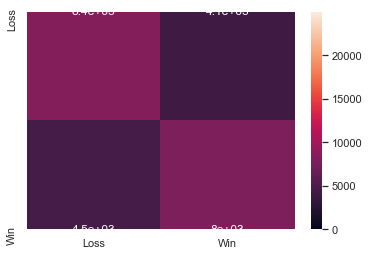

In [22]:
gb_baseline.analyze()

In [ ]:
# gb_baseline.save()

In [47]:
history = pd.DataFrame()
history.append({gb_baseline.description: [gb_baseline.accuracy, ]}, ignore_index=True)

,ohe-stats-stats
0,[0.6541278162391452]


# Gradient Boosting - Raw Data(OHE) and Raw Stats

In [28]:
def filter_raw_plus_stats_features(data: pd.DataFrame):

    print(f'Before: shape {data.shape}')

    
    default = mu.DefaultColumnFilter(data)
    raw = mu.StatsRawFilter(data)
    
    new_data = pd.concat([default.get_data(), raw.get_data()], axis=1)
    
    print(f'After: shape {data.shape}')
    
    return new_data


In [33]:
features_raw = filter_raw_plus_stats_features(features)
# let's see what's left
[col for col in stats_raw.columns if re.search("stats", col)]

Before: shape (99955, 5454)
After: shape (99955, 5454)


['p1_stats_1stin_avg',
 'p1_stats_1stwon_avg',
 'p1_stats_2ndwon_avg',
 'p1_stats_ace_avg',
 'p1_stats_bpfaced_avg',
 'p1_stats_bpsaved_avg',
 'p1_stats_df_avg',
 'p1_stats_svgms_avg',
 'p1_stats_svpt_avg',
 'p2_stats_1stin_avg',
 'p2_stats_1stwon_avg',
 'p2_stats_2ndwon_avg',
 'p2_stats_ace_avg',
 'p2_stats_bpfaced_avg',
 'p2_stats_bpsaved_avg',
 'p2_stats_df_avg',
 'p2_stats_svgms_avg',
 'p2_stats_svpt_avg']

In [34]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(features_raw, labels, random_state = RSTATE)

In [53]:

# train our model

gb = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_raw,
                   y_train = y_train_raw,
                   X_test = X_test_raw,
                   y_test = y_test_raw, 
                  data_filter = filter_raw_plus_stats_features).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3668           23.46m
         2           1.3504           22.45m
         3           1.3356           22.13m
         4           1.3238           22.27m
         5           1.3135           22.16m
         6           1.3046           21.84m
         7           1.2963           21.53m
         8           1.2894           21.28m
         9           1.2833           20.92m
        10           1.2780           20.59m
        20           1.2467           17.90m
        30           1.2296           15.78m
        40           1.2191           13.86m
        50           1.2109           11.43m
        60           1.2030            9.09m
        70           1.1965            6.88m
        80           1.1903            4.61m
        90           1.1850            2.32m
       100           1.1809            0.00s


Model Score: 0.6714554403937733

ROC/AUC Score: 0.6714526293732488
              precision    recall  f1-score   support

        Loss       0.67      0.67      0.67     12482
         Win       0.67      0.67      0.67     12507

    accuracy                           0.67     24989
   macro avg       0.67      0.67      0.67     24989
weighted avg       0.67      0.67      0.67     24989

      Loss   Win
Loss  8346  4136
Win   4074  8433


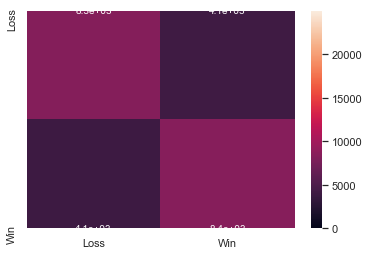

In [54]:
gb.analyze()

In [ ]:
# gb.save()

In [48]:
history.append({gb.description: [gb.accuracy, ]}, ignore_index=True)

NameError: name 'gb' is not defined

# Grandient Boosting - Raw Data(OHE) and Diff Stats

Diffed all time average player stats

In [10]:
import importlib
importlib.reload(mu)

def filter_stats_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)
    stats_diff = mu.StatsDiffFilter(data)
    new_data = pd.concat([default.get_data(), stats_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99955, 5454)
After: shape (99955, 5267)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff']

In [7]:
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(stats_diff, labels, random_state = RSTATE)

In [8]:

# train our model

gb_diff = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit()
y_predict_gb_dfiff = gb_diff.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3668           22.26m
         2           1.3504           22.67m
         3           1.3355           24.66m
         4           1.3235           26.44m
         5           1.3129           25.68m
         6           1.3036           25.43m
         7           1.2956           24.95m
         8           1.2885           24.81m
         9           1.2823           24.43m
        10           1.2770           24.24m
        20           1.2448           22.14m
        30           1.2303           18.64m
        40           1.2191           15.52m
        50           1.2108           12.57m
        60           1.2060            9.90m
        70           1.1972            7.74m
        80           1.1902            5.52m
        90           1.1850            2.88m
       100           1.1826            0.00s


Model Score: 0.6731361799191644

ROC/AUC Score: 0.6731291268429497
              precision    recall  f1-score   support

        Loss       0.68      0.67      0.67     12482
         Win       0.67      0.68      0.68     12507

    accuracy                           0.67     24989
   macro avg       0.67      0.67      0.67     24989
weighted avg       0.67      0.67      0.67     24989

      Loss   Win
Loss  8314  4168
Win   4000  8507


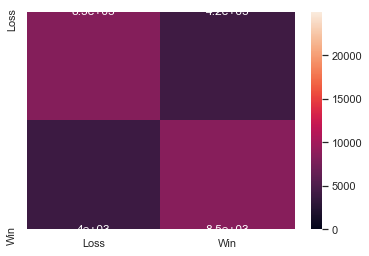

In [9]:
gb_diff.analyze()

In [ ]:
# gb_diff.save()

In [ ]:
history.append({gb_diff.description: [gb_diff.accuracy, ]}, ignore_index=True)

# Grandient Boosting - Raw Data(OHE) + stats5 diff

Average stats for each player diffed (ie, p1 - p2 stats)

In [41]:
import importlib
importlib.reload(mu)

def filter_stats5_diff_features(data: pd.DataFrame):
    
    print(f'Before: shape {data.shape}')
    
    default = mu.DefaultColumnFilter(data)

    stats_diff = mu.StatsDiffFilter(data)
    stats5_diff = mu.Stats5DiffFilter(data)

    new_data = pd.concat([default.get_data(), stats_diff.get_data(), stats5_diff.get_data()], axis=1)
    
    print(f'After: shape {new_data.shape}')
    
    return new_data

stats5_diff = filter_stats_diff_features(features)
# let's see what's left
[col for col in stats_diff.columns if re.search("stats", col)]

Before: shape (99955, 5454)
After: shape (99955, 5271)


['p1_stats_1stin_avg_diff',
 'p1_stats_1stwon_avg_diff',
 'p1_stats_2ndwon_avg_diff',
 'p1_stats_ace_avg_diff',
 'p1_stats_bpfaced_avg_diff',
 'p1_stats_bpsaved_avg_diff',
 'p1_stats_df_avg_diff',
 'p1_stats_svgms_avg_diff',
 'p1_stats_svpt_avg_diff',
 'p1_stats5_1stin_diff',
 'p1_stats5_1stwon_diff',
 'p1_stats5_2ndwon_diff',
 'p1_stats5_ace_diff',
 'p1_stats5_bpfaced_diff',
 'p1_stats5_bpsaved_diff',
 'p1_stats5_df_diff',
 'p1_stats5_svgms_diff',
 'p1_stats5_svpt_diff']

In [42]:
X_train_diff5, X_test_diff5, y_train_diff5, y_test_diff5 = train_test_split(stats5_diff, labels, random_state = RSTATE)

In [44]:
gb_diff5 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff5', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff5,
                   y_train = y_train_diff5,
                   X_test = X_test_diff5,
                   y_test = y_test_diff5, 
                  data_filter = filter_stats5_diff_features).fit()
y_predict_gb_dfiff5 = gb_diff5.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3633           31.19m
         2           1.3447           30.63m
         3           1.3292           28.86m
         4           1.3165           28.78m
         5           1.3058           28.96m
         6           1.2969           27.45m
         7           1.2892           26.22m
         8           1.2828           25.21m
         9           1.2773           24.40m
        10           1.2728           23.69m
        20           1.2494           19.50m
        30           1.2400           16.43m
        40           1.2341           14.06m
        50           1.2299           11.55m
        60           1.2263            9.24m
        70           1.2227            6.89m
        80           1.2202            4.55m
        90           1.2179            2.26m
       100           1.2158            0.00s


Model Score: 0.6600904397935091

ROC/AUC Score: 0.6600822526726804
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.66     12482
         Win       0.66      0.67      0.66     12507

    accuracy                           0.66     24989
   macro avg       0.66      0.66      0.66     24989
weighted avg       0.66      0.66      0.66     24989

      Loss   Win
Loss  8137  4345
Win   4149  8358


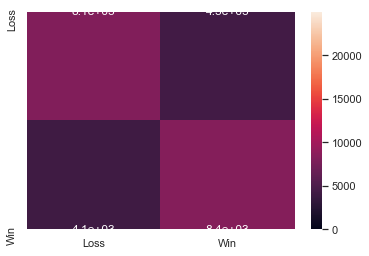

In [46]:
gb_diff5.analyze()

In [ ]:
# gb_diff5.save()

In [ ]:
history.append({gb_diff5.description: [gb_diff5.accuracy, ]}, ignore_index=True)

# Sample Weights

We saw from inital EDA, that upset rate is changing over the past couple of decades which means that earlier samples may not be as meaningful in our predictions as later samples. We will assign weights to our samples according to the year the tournament was in.

This first method assigns a different weight to each year with the last year in our samples 2018 having the highest weight.

We will compare results with the best so far:

```
Model Score: 0.6731361799191644

ROC/AUC Score: 0.6731291268429497
              precision    recall  f1-score   support

        Loss       0.68      0.67      0.67     12482
         Win       0.67      0.68      0.68     12507

    accuracy                           0.67     24989
   macro avg       0.67      0.67      0.67     24989
weighted avg       0.67      0.67      0.67     24989
```

In [ ]:
importlib.reload(mu)
# assign sample weights
ywc = mu.YearWeightCalculator(X_train_diff)
gb_diff_ywc = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_year', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train_diff,
                   y_train = y_train_diff,
                   X_test = X_test_diff,
                   y_test = y_test_diff, 
                  data_filter = filter_stats_diff_features).fit(sample_weights = ywc.get_weights())
y_predict_gb_diff_ywc = gb_diff_ywc.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3658           21.30m
         2           1.3489           21.29m
         3           1.3342           21.28m
         4           1.3216           21.22m
         5           1.3107           20.97m
         6           1.3012           20.78m
         7           1.2931           20.59m
         8           1.2853           20.36m
         9           1.2789           20.15m
        10           1.2730           19.93m
        20           1.2283           17.73m
        30           1.2056           15.42m
        40           1.1922           13.45m


In [ ]:
gb_diff_ywc.analyze()

In [ ]:
# gb_diff_ywc.save()

In [ ]:
history.append({gb_diff_ywc.description: [gb_diff_ywc.accuracy, ]}, ignore_index=True)

# Sample Weights - 10 bin

With this method, we will take years of tournament and construct equal sized bins. We wills start with 10 bins

We will compare results to the following:

```

```

In [ ]:
# assign sample weights
ybwc10 = mu.YearBinWeightCalculator(X_train_diff, 10)
gb_diff_yb10 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_year_bin10', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features).fit(X_train_diff, y_train_diff, sample_weights = ybwc10.get_weights())
y_predict_gb_diff_yb10 = gb_diff_yb10.predict(X_test_diff)

In [ ]:
gb_diff_yb10.analyze(y_test_diff)

In [ ]:
# gb_diff_yb10.save()

In [ ]:
history.append({gb_diff_yb10.description: [gb_diff_yb10.accuracy, ]}, ignore_index=True)

# Sample Weights - 4 bin

Since we saw in EDA that there might be a significant drop or increase in upset rates every 5 years. Our data covers 20 years, so let's try using 4 bins and see how this affects our model


We will compare results to the following:

```

```

In [ ]:
# assign sample weights
ybwc4 = mu.YearBinWeightCalculator(X_train_diff, 4)
gb_diff_yb4 = mu.ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = f'{DESCRIPTION}-stats_diff-weights_year_bin4', 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                  data_filter = filter_stats_diff_features).fit(X_train_diff, y_train_diff, sample_weights = ybwc4.get_weights())
y_predict_gb_diff_yb4 = gb_diff_yb4.predict(X_test_diff)

In [ ]:
gb_diff_yb4.analyze(y_test_diff)

In [ ]:
# gb_diff_yb4.save()

In [ ]:
history.append({gb_diff_yb4.description: [gb_diff_yb4.accuracy, ]}, ignore_index=True)

# Results

In [29]:
report = pd.read_csv(ModelWrapper.REPORT_FILE)
report.tail(6)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
90,LogisticRegression,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.662525,0.662528,"{""0"": {""0"": 4896, ""1"": 2513}, ""1"": {""0"": 2485,...","{""Loss"": {""precision"": 0.6608179241463086, ""re...",../models/logisticregression-1998-2018-ohe-mat...,0.0,0.0,0.0
91,KNeighborsClassifier,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.608845,0.608854,"{""0"": {""0"": 4513, ""1"": 2925}, ""1"": {""0"": 2868,...","{""Loss"": {""precision"": 0.6067491261091691, ""re...",../models/kneighborsclassifier-1998-2018-ohe-m...,0.0,0.0,0.0
92,DecisionTreeClassifier,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.602836,0.602816,"{""0"": {""0"": 4404, ""1"": 2905}, ""1"": {""0"": 2977,...","{""Loss"": {""precision"": 0.602544807771241, ""rec...",../models/decisiontreeclassifier-1998-2018-ohe...,0.0,0.0,0.0
93,RandomForestClassifier,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.640581,0.640837,"{""0"": {""0"": 5313, ""1"": 3255}, ""1"": {""0"": 2068,...","{""Loss"": {""precision"": 0.6200980392156863, ""re...",../models/randomforestclassifier-1998-2018-ohe...,0.0,0.0,0.0
94,GradientBoostingClassifier,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.683862,0.683843,"{""0"": {""0"": 5004, ""1"": 2305}, ""1"": {""0"": 2377,...","{""Loss"": {""precision"": 0.6846353810370776, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,8.0,8.0
95,AdaBoostClassifier,ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-ohe...,1998,2018,0.666442,0.666390,"{""0"": {""0"": 4802, ""1"": 2361}, ""1"": {""0"": 2579,...","{""Loss"": {""precision"": 0.6703895016054726, ""re...",../models/adaboostclassifier-1998-2018-ohe-mat...,0.0,1.0,1.0


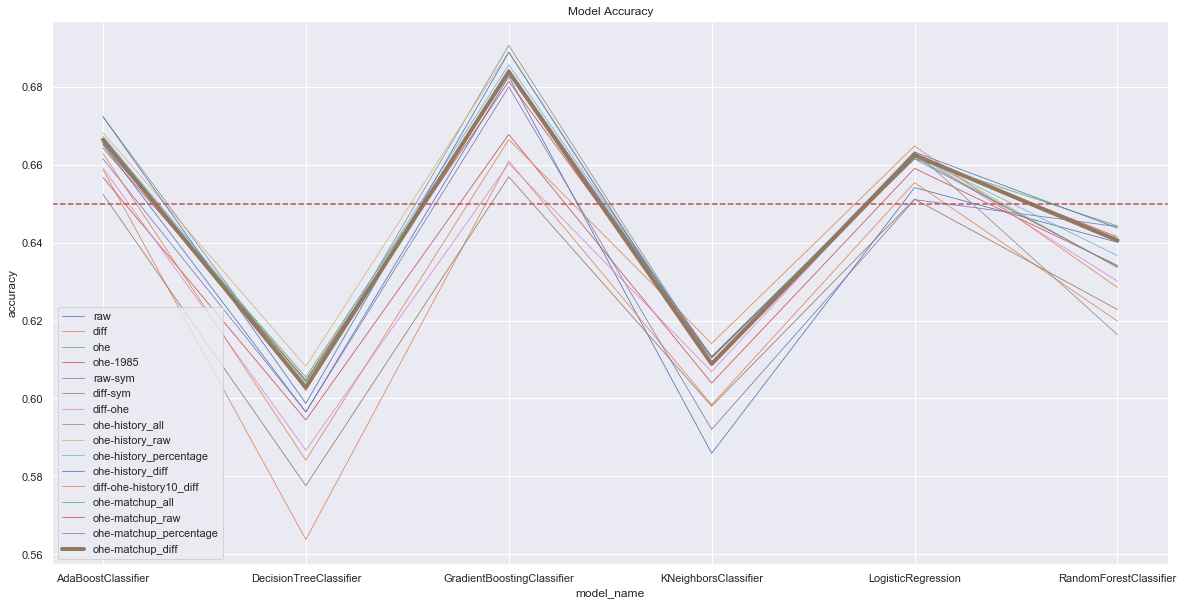

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

Best Model: GradientBoostingClassifier


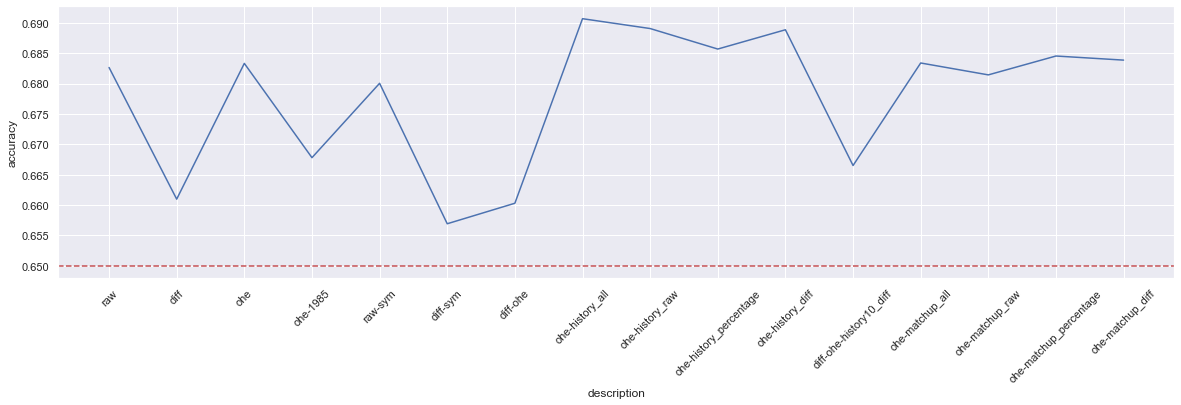

In [31]:
best_model = report.loc[report[report.description == DESCRIPTION].accuracy.idxmax()].model_name
print(f'Best Model: {best_model}')

dt_report = report[(report.model_name == best_model)]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.axhline(0.65, ls='--', color='r')
_ = a.set_label(f"{best_model} Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
current_report = report[(report.model_name == 'GradientBoostingClassifier') &
                                  (report.description == DESCRIPTION)]
mw = ModelWrapper.get_model_wrapper_from_report(current_report)


In [33]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)

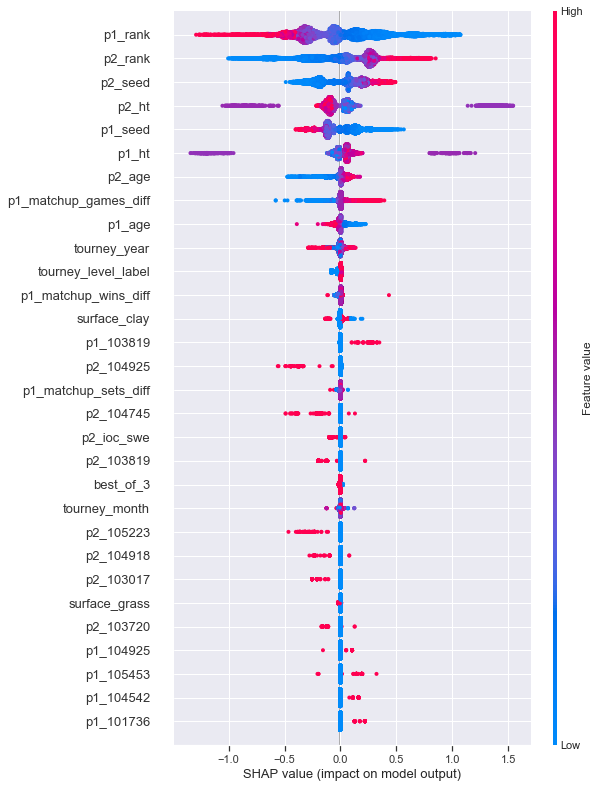

In [34]:
shap.summary_plot(shap_values, X_test, max_display=30)

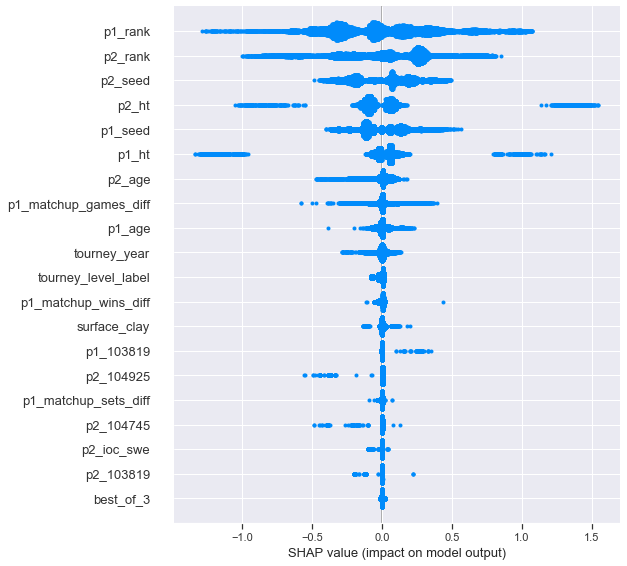

In [35]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [36]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-10-21 04:39
